# Dataset loading

In [29]:
df_1 = pd.read_csv('birth_sex.csv')
mask = ['2023' in opd for opd in df_1['생년월일'].values]
df_1[mask]
#df_o[df_o['hid']==81043479]

,hid,성별,생년월일
90848,81042027,M,2023-01-30
90849,81043479,F,2023-01-31


In [200]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv

df0 = pd.read_csv('tube.csv')
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['age'] <= 10]
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']
df = df.loc[~df['airway_tube_size'].isnull()]
df.dropna(subset=['age', 'sex'], inplace=True)
df['sex'] = (df['sex'] == 'M')

INPUT_VARS = ['age','sex','weight','height']
TARGET_VAR = 'airway_tube_size'

OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 

## Adding age(month)

In [202]:
import pandas as pd

df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))


df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

### validation

In [203]:
df2 = df.loc[df['age_cal'] < 1/12]
df2['age(days)'] = df2['age_cal'] * 12 * 30
df2[['opid','sex','weight','height','airway_tube_size','age(days)']]

/tmp/ipykernel_942143/1082037650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['age(days)'] = df2['age_cal'] * 12 * 30


,opid,sex,weight,height,airway_tube_size,age(days)
26,50825110,False,2.10,43.5,3.0,1.971293
107,50902079,True,3.40,NaN,3.5,24.641163
155,50906101,True,4.10,NaN,2.5,10.842112
206,50910004,True,2.05,46.0,2.5,3.942586
234,50913081,False,3.10,50.0,3.0,26.612456
...,...,...,...,...,...,...
61866,221109149,True,4.82,55.0,4.0,0.985647
61884,221117134,True,3.90,53.0,3.0,15.770344
61891,221121129,False,3.23,51.0,3.5,12.813405
61894,221121132,True,2.01,43.5,3.5,2.956940


In [206]:
df = df.loc[df['age_cal'] <= 10]
df = df.loc[df['age_cal'] > 0]

In [84]:
np.max(age_lis), np.min(age_lis), np.mean(age_lis)

(9.99883638952203, 0.002737907006988508, 3.5769446424896336)

(array([15348.,  8686.,  6206.,  5042.,  4899.,  4888.,  4361.,  3335.,
         3182.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <BarContainer object of 9 artists>)

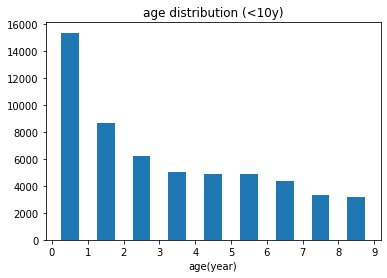

In [106]:
import matplotlib.pyplot as plt

age_lis = df['age_cal'].values
plt.title('age distribution (<10y)')
plt.xlabel('age(year)')
plt.xticks(np.arange(0,10,1))
plt.hist(age_lis, bins=np.arange(0,10,1), rwidth=0.5)

## Dataset

In [91]:
random.seed(0)
df = shuffle(df)
y = df[[TARGET_VAR]].values.flatten().astype(float)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]


# encoding : 2 -> 0, 2.5 -> 1, ... 8.5 -> 14 로 tube size x 2 - 4
df['label'] = df[TARGET_VAR].apply(lambda x: x*2-4)

for i in range(14):
    df[f'{i}'] = df['label'].apply(lambda x: 1 if x==i else 0)
    
y_label = df[[f'{i}' for i in range(14)]].values
yl_test = y_label[-ntest:]
yl_train = y_label[:ntrain]

### ETT size

In [93]:
print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.720
mean_squared_errors: 0.293
r2_score: 0.701
acc: 0.368
acc(+-0.5mm): 0.879


### ETT insertion depth

## 결측치 채우기 (multi-imputer)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

# 1. XGBoost model

In [95]:
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')


xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((y_pred == x) & (y_test == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals_old, label='4+AGE/4')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.savefig('old.png')
plt.close()

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals, label='GBRT')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.savefig('new.png')
plt.close()

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')


# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'regression model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'colsample_bytree': 0.8}
0.8067772022468374
--------------
old model = age/4+4
--------------
explained_variance_score: 0.720
mean_squared_errors: 0.293
r2_score: 0.701
acc: 0.368
acc(+-0.5mm): 0.879
--------------
new model
--------------
explained_variance_score: 0.792
mean_squared_errors: 0.204
r2_score: 0.792
acc: 0.454
acc(+-0.5mm): 0.927


# Sampling & validation

In [114]:
df_op[df_op['opid']==90805111]

,opid,hid,opdate,orin,orout
34573,90805111,75656863,2009-08-05,2009-08-05 08:12:00,2009-08-05 14:20:00


In [116]:
df2[df2['opid']==90805111]

,opid,sex,age,weight,height,airway_tube_size,airway_tube_type,airway_lma,old_tube_size,age_cal,...,5,6,7,8,9,10,11,12,13,age(days)
15909,90805111,True,0,44.45,150.4,3.0,plain,NaN,3.5,0.027379,...,0,0,0,0,0,0,0,0,0,9.856465


In [115]:
df_weight[df_weight['hid']==75656863]

,hid,기록작성일시,Attribute,Value,기록작성일
534243,75656863,2009-07-26 09:17:00,체중,2.66,2009-07-26
534244,75656863,2009-08-17 14:00:00,체중,2.8,2009-08-17
534245,75656863,2009-08-18 09:00:00,체중,2.8,2009-08-18
534246,75656863,2009-08-19 09:00:00,체중,2.7,2009-08-19
534247,75656863,2009-08-20 09:00:00,체중,2.8,2009-08-20
534248,75656863,2009-08-21 09:00:00,체중,2.9,2009-08-21
534249,75656863,2009-08-06 08:00:00,체중,2.88,2009-08-06
534250,75656863,2009-08-08 08:00:00,체중,2.78,2009-08-08
534251,75656863,2009-08-09 08:00:00,체중,2.96,2009-08-09
534252,75656863,2009-08-10 00:00:00,체중,-,2009-08-10


In [209]:
df_weight[df_weight['hid']==80573472]

,hid,기록작성일시,Attribute,weight,기록작성일
1366996,80573472,2022-11-29 12:42:00,체중,9.9,2022-11-29
1366997,80573472,2022-11-29 13:14:19,체중,9.9,2022-11-29
1366998,80573472,2022-11-30 08:00:00,체중,10.3,2022-11-30
1366999,80573472,2022-12-03 17:00:00,체중,10.2,2022-12-03
1367000,80573472,2022-12-04 08:00:00,체중,9.9,2022-12-04
1367001,80573472,2022-12-04 17:00:00,체중,9.9,2022-12-04
1367002,80573472,2022-12-05 08:13:00,체중,9.8,2022-12-05
1367003,80573472,2022-12-05 17:00:00,체중,9.8,2022-12-05
1367004,80573472,2022-12-06 08:00:00,체중,10.1,2022-12-06
1367005,80573472,2022-11-30 12:13:00,체중,10.8,2022-11-30


In [207]:
df_r = pd.read_csv('demography_revised.csv')
df_r[df_r['opid']==221130132]

,Unnamed: 0,Unnamed: 0.1,opid,hid,opdate,orin,orout,기록작성일시,Attribute,weight,기록작성일,기록작성일_x,height
151640,151640,151640,221130132,80573472,2022-11-30,2022-11-30 08:07:00,2022-11-30 12:20:00,2022-11-30 08:00:00,체중,10.3,2022-11-30,2022-11-29,72.7


In [ ]:
df_r = pd.read_csv('demography_revised.csv')
df_r[df_r['opid']==90805111]

In [133]:
df_op = pd.read_csv('opdates.csv')
df_weight = pd.read_csv('weight_raw.csv')
df_weight.rename(columns={'Value':'weight'}, inplace=True)
df_height = pd.read_csv('height_raw.csv')
df_height.rename(columns={'Value':'height'}, inplace=True)

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [134]:
df_op['opdate'] = df_op['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_weight['기록작성일'] = df_weight['기록작성일'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_height['기록작성일'] = df_height['기록작성일'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [135]:
df = pd.merge_asof(df_op.sort_values('opdate'), df_weight.sort_values('기록작성일'), 
                   left_on='opdate', direction='backward', tolerance=pd.Timedelta(days=30), 
                   right_on='기록작성일', by='hid', suffixes=('', '_x'))

In [136]:
df = pd.merge_asof(df.sort_values('opdate'), df_height[['기록작성일','hid','height']].sort_values('기록작성일'), 
                   left_on='opdate', direction='backward', tolerance=pd.Timedelta(days=30), 
                   right_on='기록작성일', by='hid', suffixes=('', '_x'))

In [137]:
df

,opid,hid,opdate,orin,orout,기록작성일시,Attribute,weight,기록작성일,기록작성일_x,height
0,41005007,33254768,2004-10-05,2004-10-05 14:00:00,2004-10-05 15:30:00,2004-10-05 12:27:49,체중,64,2004-10-05,2004-10-05,182
1,41012007,32240951,2004-10-12,2004-10-12 15:10:00,2004-10-12 16:30:00,NaN,NaN,NaN,NaT,NaT,NaN
2,41013003,32944099,2004-10-13,2004-10-13 16:00:00,2004-10-13 18:30:00,2004-10-11 16:00:17,체중,60.1,2004-10-11,2004-10-11,167
3,41015007,73279493,2004-10-15,2004-10-15 08:50:00,2004-10-15 10:40:00,2004-10-14 20:52:57,체중,27.8,2004-10-14,2004-10-14,105
4,41015010,74294286,2004-10-15,2004-10-15 20:00:00,2004-10-15 22:20:00,2004-10-15 22:10:57,체중,17,2004-10-15,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...
153247,230131172,78554928,2023-01-31,2023-01-31 15:49:00,2023-01-31 16:45:00,2023-01-31 10:13:00,체중,20.7,2023-01-31,2023-01-31,120
153248,230131173,78798331,2023-01-31,2023-01-31 16:56:00,2023-01-31 17:55:00,2023-01-31 12:00:00,체중,23,2023-01-31,2023-01-31,124.4
153249,230131156,80983358,2023-01-31,2023-01-31 13:07:00,2023-01-31 13:36:00,2023-01-31 10:28:00,체중,21.5,2023-01-31,2023-01-31,117
153250,230131155,80880581,2023-01-31,2023-01-31 10:25:00,2023-01-31 12:49:00,2023-01-31 08:54:00,체중,62.7,2023-01-31,2023-01-31,156.3


In [148]:
#df[df['weight']=='7..1']
df[df['weight']=='11.6(cast)']

,Unnamed: 0,opid,hid,opdate,orin,orout,기록작성일시,Attribute,weight,기록작성일,기록작성일_x,height
824,824,41206090,74253069,2004-12-06,2004-12-06 08:00:00,2004-12-06 08:50:00,2004-12-03 11:00:00,체중,11.6(cast),2004-12-03,NaN,NaN


In [152]:
ab = df.loc[0,'height']
type(ab)

str

In [191]:
df = pd.read_csv('demography_revised.csv')
#df = df.astype({'height':'float', 'weight':'float'}, copy=True, errors='ignore')

In [187]:
def str_to_float(inp):
    try:
        return float(inp)
    except:
        return np.nan

In [192]:
df['height'] = df['height'].apply(lambda x: str_to_float(x))
df['weight'] = df['weight'].apply(lambda x: str_to_float(x))

In [171]:
df['height'] =df1['height'].apply(lambda x: x if type(x)==float else np.nan)
df['weight'] =df1['weight'].apply(lambda x: x if type(x)==float else np.nan)

In [194]:
df.to_csv('demography_revised.csv')